In [32]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor
# from azure.quantum.qiskit import AzureQuantumProvider
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.utils import QuantumInstance

import numpy as np
from scipy.linalg import block_diag
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult, approx_fprime
import math


p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])

# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853


def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        grad[i] = (f_plus_h - f) / eps
    print("eps: ", eps)
    return f, grad


def adam(fun, x0, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        print("Iter: ", nit)
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)
        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result


def get_probability_distribution_2(counts, NUM_SHOTS):
    #   output_distr = [v/NUM_SHOTS for v in counts.values()]
    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())
    # print(sorted_counts)
    output_distr = [v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr


class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []
        self.shots = []


def simulator_std_estimation(theta, per_shots):
    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=per_shots, memory=True)
    result = job.result()
    experiments = np.zeros((per_shots, 4))
    print("Experiments: ", experiments)

    for idx, exp in enumerate(result.get_memory()):
        if exp == '00':
            experiments[idx, 0] = 1
        elif exp == '01':
            experiments[idx, 1] = 1
        elif exp == '10':
            experiments[idx, 2] = 1
        else:
            experiments[idx, 3] = 1

    E1_ = -g1 * (experiments[:,0] + experiments[:,1] - experiments[:,2] - experiments[:,3])
    E2_ = -g2 * (experiments[:,0] - experiments[:,1] + experiments[:,2] - experiments[:,3])
    E3_ = g3 * (experiments[:,0] - experiments[:,1] - experiments[:,2] + experiments[:,3])
    print("E1_, E2_, E3_,", E1_, E2_, E3_)
    G13_ = E1_ + E2_ + E3_
    
    # job = qpu_backend.run(circ_2, shots=shots2)
    job = execute(circ_2, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=per_shots, memory=True)
    result = job.result()
    experiments = np.zeros((per_shots, 4))
    for idx, exp in enumerate(result.get_memory()):
        if exp == '00':
            experiments[idx, 0] = 1
        elif exp == '01':
            experiments[idx, 1] = 1
        elif exp == '10':
            experiments[idx, 2] = 1
        else:
            experiments[idx, 3] = 1
    E4_ = g4 * (experiments[:,0] - experiments[:,1] - experiments[:,2] + experiments[:,3])
    G4_ = E4_



    job = execute(circ_3, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=per_shots, memory=True)
    result = job.result()
    experiments = np.zeros((per_shots, 4))
    for idx, exp in enumerate(result.get_memory()):
        if exp == '00':
            experiments[idx, 0] = 1
        elif exp == '01':
            experiments[idx, 1] = 1
        elif exp == '10':
            experiments[idx, 2] = 1
        else:
            experiments[idx, 3] = 1

    E5_ = g5 * (experiments[:,0] - experiments[:,1] - experiments[:,2] + experiments[:,3])
    G5_ = E5_
    return G13_, G4_, G5_


def simulator(theta, shots, std_shots, history):
    E = g0 + nuclear_repulsion

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    print("Theta: ", theta)
    print("Std_shots: ", std_shots)
    G13, G4, G5 = simulator_std_estimation(theta, std_shots)
    print("G13: ", G13)
    print("std_G13", np.std(G13))
    print("std_G4", np.std(G4))
    print("std_G5", np.std(G5))

    std = [np.std(G13), np.std(G4), np.std(G5)]

    if sum(std)==0:
        ratio_for_theta = [1/3, 1/3, 1/3]
    else:
        ratio_for_theta = [v/sum(std) for v in std]
    
    print("Ratio For Theta", ratio_for_theta)

    pershots = shots//3

    # NEW SHOTS EQUATION
    newshots = (shots - std_shots*3)
    print("Shots: ", shots,"Shots-std: ", std_shots,"Newshots: ", newshots)

    shots1 = round(newshots * ratio_for_theta[0])
    if shots1 < 1:
        shots1 = 1

        
    shots2 = round(newshots * ratio_for_theta[1])
    if shots2 < 1:
        shots2 = 1

    shots3 = round(newshots * ratio_for_theta[2])
    if shots3 < 1:
        shots3 = 1

    history.shots.append(shots1+shots2+shots3+std_shots*3)
    print('current assignment {} {} {} std shot assignment {}'.format(shots1, shots2, shots3, std_shots))


    job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    print("N-mk, E1, E2, E3", E1, E2, E3)
    E += (shots1*(E1 + E2 + E3) + np.sum(G13))/(shots1+std_shots)

    job = execute(circ_2, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E4 = g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += (shots2*E4 + np.sum(G4))/(shots2+std_shots)
    history.P2.append(output_distr)

    job = execute(circ_3, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E5 = g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += (shots3*E5 + np.sum(G5))/(shots3+std_shots)
    history.P3.append(output_distr)

    history.thetas.append(theta[0])
    history.energies.append(E)

    print('energy track: ', history.energies[-1])

    return E

In [33]:
theta_test = [-2]

record_history = history()
shots = 600
std_shots = 5

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=shots, std_shots=std_shots, history=record_history), theta_test, iters=500, eps=0.02)


Iter:  0
Theta:  [-2]
Std_shots:  5
Experiments:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
E1_, E2_, E3_, [-0.1615 -0.1615  0.1615 -0.1615  0.1615] [-0.0166 -0.0166  0.0166 -0.0166  0.0166] [-0.4148 -0.4148 -0.4148 -0.4148 -0.4148]
G13:  [-0.5929 -0.5929 -0.2367 -0.5929 -0.2367]
std_G13 0.1745016492758736
std_G4 0.0
std_G5 0.0
Ratio For Theta [1.0, 0.0, 0.0]
Shots:  600 Shots-std:  5 Newshots:  585
current assignment 585 1 1 std shot assignment 5
N-mk, E1, E2, E3 0.07481452991452991 0.00768991452991453 -0.4148
energy track:  -0.3454096159694916
Theta:  [-1]
Std_shots:  5
Experiments:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
E1_, E2_, E3_, [-0.1615  0.1615  0.1615 -0.1615  0.1615] [-0.0166  0.0166  0.0166 -0.0166  0.0166] [-0.4148 -0.4148 -0.4148 -0.4148 -0.4148]
G13:  [-0.5929 -0.2367 -0.2367 -0.5929 -0.2367]
std_G13 0.1745016492758736
std_G4 0.09808
std_G5 0.0
Ratio For Theta [0.6401812071335167, 0.3598187928664835

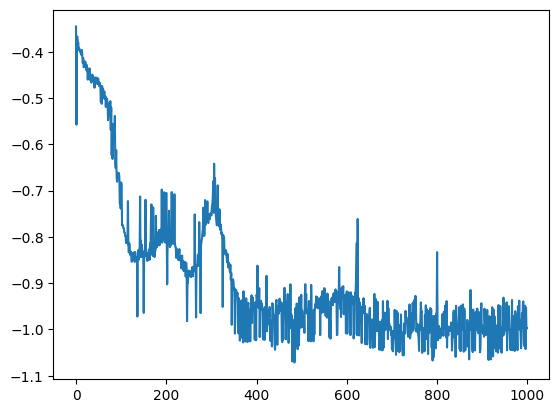

In [34]:
import matplotlib.pyplot as plt 
plt.plot(record_history.energies)

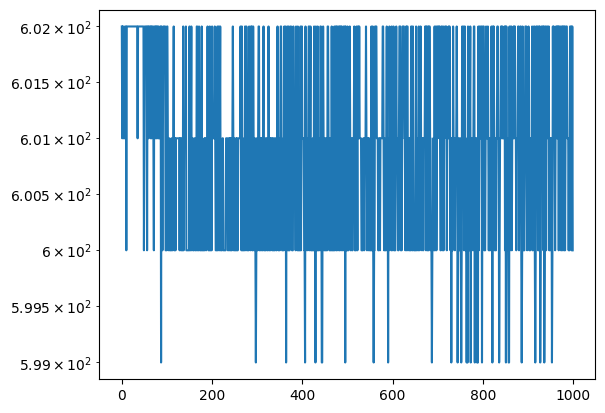

In [36]:
import matplotlib.pyplot as plt 
plt.plot(record_history.shots)
plt.yscale('log')

In [4]:
theta_test = [0]

record_history = history()
shots = 60
std_shots = 5

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=shots, std_shots=std_shots, history=record_history), theta_test, iters=500, eps=0.02)


0
60 45 45
current assignment 1 22 22 std shot assignment 5
energy track:  -0.9137833761703704
60 45 45
current assignment 1 45 1 std shot assignment 5
energy track:  -0.9564663391333335
0.02
1
60 45 45
current assignment 1 20 25 std shot assignment 5
energy track:  -0.8371356724666668
60 45 45
current assignment 1 20 25 std shot assignment 5
energy track:  -0.8453090058000001
0.02
2
60 45 45
current assignment 1 1 45 std shot assignment 5
energy track:  -0.9777170058000002
60 45 45
current assignment 1 20 25 std shot assignment 5
energy track:  -0.8959836724666669
0.02
3
60 45 45
current assignment 1 22 22 std shot assignment 5
energy track:  -0.8411315243185187
60 45 45
current assignment 19 13 13 std shot assignment 5
energy track:  -0.8626157835777777
0.02
4
60 45 45
current assignment 1 22 22 std shot assignment 5
energy track:  -0.904701894688889
60 45 45
current assignment 1 45 1 std shot assignment 5
energy track:  -0.9581010058000002
0.02
5
60 45 45
current assignment 1 25 20 